<a href="https://colab.research.google.com/github/nhanphm/embryos/blob/main/Train_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare dataset: Convert json format to mask image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/')


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [31]:
import os
import datetime
import glob
import random
import sys

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

INPUT_SHAPE = 256
OUTPUT_SHAPE = 256
img_height = INPUT_SHAPE
img_width = OUTPUT_SHAPE

import random
seed = 42
random.seed = seed
np.random.seed(seed=seed)
from tensorflow import set_random_seed
set_random_seed(seed)

In [5]:
from sklearn.model_selection import train_test_split
import glob2

train_image_paths = glob2.glob('/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/embryos-622/train/image/*.png')
train_label_paths = ['/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/embryos-622/train/label/' + path.split('/')[-1] for path in train_image_paths]

val_image_paths = glob2.glob('/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/embryos-622/val/image/*.png')
val_label_paths = ['/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/embryos-622/val/label/' + path.split('/')[-1] for path in val_image_paths]


In [6]:
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to creat
from skimage.util import img_as_ubyte

# Get training data
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = path
    X_data = np.array([img_as_ubyte(skimage.transform.resize(skimage.io.imread(path, as_gray=True), output_shape=output_shape+(1,), mode='constant', preserve_range=True)) for path in img_paths])  #take only 3 channels/bands
    
    return X_data
X_trainz = get_X_data(train_image_paths, output_shape=(img_height,img_width))
X_valz = get_X_data(val_image_paths, output_shape=(img_height,img_width))
print(X_trainz.shape, X_trainz.dtype)
print(X_valz.shape, X_valz.dtype)


(319, 256, 256, 1) uint8
(105, 256, 256, 1) uint8


In [7]:
# Get training data labels
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = path
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data
Y_trainz = get_Y_data(train_label_paths, output_shape=(img_height,img_width))
Y_valz = get_Y_data(val_label_paths, output_shape=(img_height,img_width))
print(Y_trainz.shape, Y_trainz.dtype)
print(Y_valz.shape, Y_valz.dtype)


(319, 256, 256, 1) bool
(105, 256, 256, 1) bool


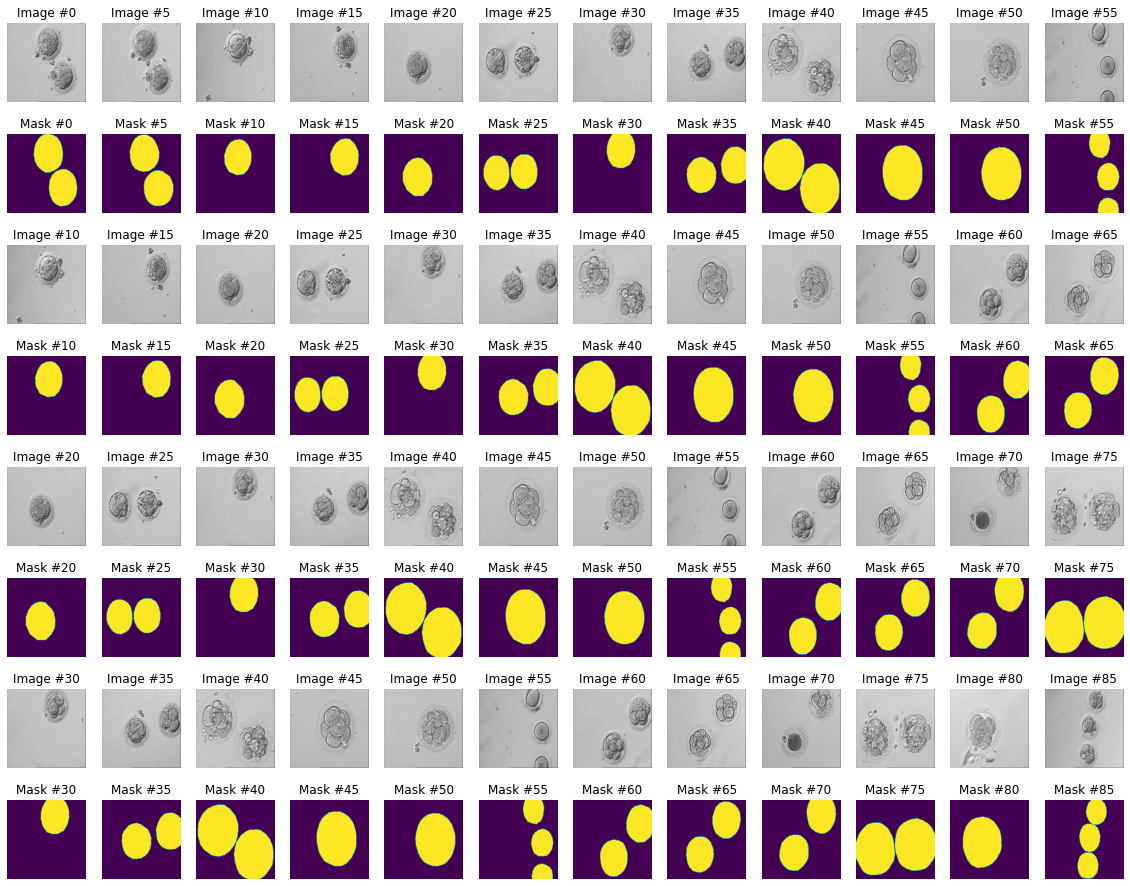

In [8]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*10 + j*5
        plt.imshow(np.squeeze(X_trainz[pos]), cmap='gray', vmin=0, vmax=255)
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_trainz[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
#plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [42]:
# Design our model architecture here
def keras_model(img_width=OUTPUT_SHAPE, img_height=OUTPUT_SHAPE):
    '''
    Modified from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/
    '''
    n_ch_exps = [4, 5, 6, 7, 8, 9]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer

    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (1, img_width, img_height)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_width, img_height, 1)

    inp = Input(shape=input_shape)
    encodeds = []

    # encoder
    enc = inp
    print(n_ch_exps)
    for l_idx, n_ch in enumerate(n_ch_exps):
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        enc = Dropout(0.1*l_idx,)(enc)
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        encodeds.append(enc)
        #print(l_idx, enc)
        if n_ch < n_ch_exps[-1]:  #do not run max pooling on the last encoding/downsampling step
            enc = MaxPooling2D(pool_size=(2,2))(enc)
    
    # decoder
    dec = enc
    print(n_ch_exps[::-1][1:])
    decoder_n_chs = n_ch_exps[::-1][1:]
    for l_idx, n_ch in enumerate(decoder_n_chs):
        l_idx_rev = len(n_ch_exps) - l_idx - 2  #
        dec = Conv2DTranspose(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = concatenate([dec, encodeds[l_idx_rev]], axis=ch_axis)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = Dropout(0.1*l_idx)(dec)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)

    outp = Conv2DTranspose(filters=1, kernel_size=k_size, activation='sigmoid', padding='same', kernel_initializer='glorot_normal')(dec)

    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [10]:
# Custom IoU metric, precision, f1_score and recall
from keras import backend as K
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [21]:
# Custom loss function
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


In [43]:
import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras import backend as K
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

# Set some model compile parameters
optimizer = 'adam'
loss      = bce_dice_loss
metrics   = [[mean_iou, f1_m, precision_m, recall_m]]
# Compile our model
model = keras_model(img_width=img_width, img_height=img_height)
model.summary()


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4]
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 256, 256, 16) 160         input_9[0][0]                    
__________________________________________________________________________________________________
dropout_89 (Dropout)            (None, 256, 256, 16) 0           conv2d_177[0][0]                 
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 256, 256, 16) 2320        dropout_89[0][0]                 
_________________________________________________________

In [13]:
# Runtime data augmentation
def get_train_test_augmented(X_train=X_trainz, Y_train=Y_trainz, X_test = X_valz, Y_test = Y_valz, batch_size=32, seed=seed):
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator, X_train, X_test, Y_train, Y_test

In [14]:
# Runtime custom callbacks
#%% https://github.com/deepsense-ai/intel-ai-webinar-neural-networks/blob/master/live_loss_plot.py
# Fixed code to enable non-flat loss plots on keras model.fit_generator()
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

plot_losses = PlotLosses(figsize=(16, 4))

In [45]:
#custom early stopping
custom_early_stopping = EarlyStopping(
    monitor='val_mean_iou', 
    patience=50, 
    min_delta=0.0001, 
    mode='max'
)

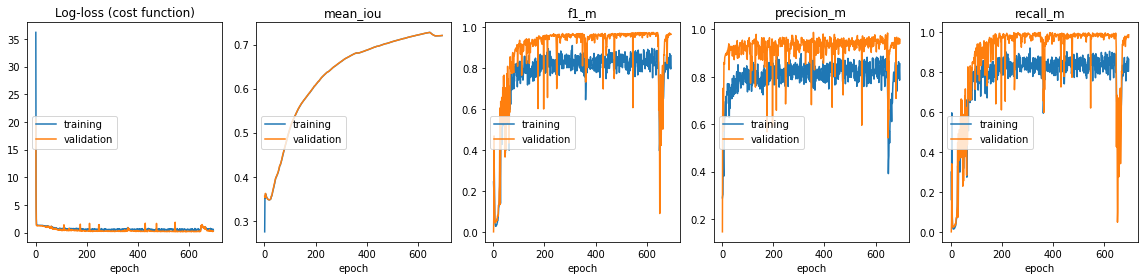

In [46]:
# Finally train the model!!
batch_size = 16

train_generator, test_generator, X_train, X_val, Y_train, Y_val = get_train_test_augmented(X_train=X_trainz, Y_train=Y_trainz, X_test = X_valz, Y_test = Y_valz, batch_size=batch_size)
# increase epoch on your own machine
history = model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2, steps_per_epoch=len(X_train)/(batch_size*2), epochs=10000, callbacks=[custom_early_stopping, plot_losses])

In [ ]:
#model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2, steps_per_epoch=len(X_train)/(batch_size*2), epochs=1000, callbacks=[PlotLossesKeras()])

In [ ]:
#model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2, steps_per_epoch=len(X_train)/(batch_size*2), epochs=2000, callbacks=[PlotLossesKeras()])

In [47]:
model.save_weights('/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/model-weights.h5')

In [48]:
# Save my model config and weight
model.save('/content/drive/MyDrive/LuanVan_Embryos_segment/Unet/mymodel')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model